In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

In [2]:
#hyperparams

num_epochs = 100  # Batches are inside epochs
total_series_length = 50000  
truncated_backprop_length = 15  # 
state_size = 4  # No. of neurons in hidden layer ( 3 layer neural net)
num_classes = 2  # No. of classes ( 0 and 1 )
echo_step = 3  # 
batch_size = 5  # Inside epoch
num_batches = total_series_length//batch_size//truncated_backprop_length  # No. of batches

In [3]:
# Step 1 Collect data
def generateData():
    # 0,1 50k samples
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    # Shift 3 steps to left
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    x = x.reshape((batch_size, -1)) 
    y = y.reshape((batch_size, -1))
    
    return (x, y)

data = generateData()

print(data)

(array([[0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64), array([[0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]], dtype=int64))


In [4]:
#Schematic of the reshaped data-matrix, arrow curves shows adjacent time-steps that ended up on different rows. 
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [5]:
#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#Step 2 - Build the Model

#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [6]:
#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [7]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [8]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unpack columns
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [10]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.

In [14]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat(axis=1, values=[current_input, current_state])  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state

In [15]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

In [17]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [18]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.708804
Step 100 Loss 0.700659
Step 200 Loss 0.69147
Step 300 Loss 0.688803
Step 400 Loss 0.692897
Step 500 Loss 0.684777
Step 600 Loss 0.572007
New data, epoch 1
Step 0 Loss 0.421411
Step 100 Loss 0.0407428
Step 200 Loss 0.0169775
Step 300 Loss 0.0112504
Step 400 Loss 0.00808688
Step 500 Loss 0.00836783
Step 600 Loss 0.00584262
New data, epoch 2
Step 0 Loss 0.397992
Step 100 Loss 0.00514043
Step 200 Loss 0.00390044
Step 300 Loss 0.00317126
Step 400 Loss 0.004362
Step 500 Loss 0.00361888
Step 600 Loss 0.00268734
New data, epoch 3
Step 0 Loss 0.24638
Step 100 Loss 0.00261539
Step 200 Loss 0.00223732
Step 300 Loss 0.00199044
Step 400 Loss 0.00184866
Step 500 Loss 0.00187744
Step 600 Loss 0.00185572
New data, epoch 4
Step 0 Loss 0.158465
Step 100 Loss 0.00143004
Step 200 Loss 0.001459
Step 300 Loss 0.00175557
Step 400 Loss 0.00139214
Step 500 Loss 0.00142209
Step 600 Loss 0.00138144
New data, epoch 5
Step 0 Loss 0.314336
Step 100 Loss 0.000978642
Step 200 Lo

KeyboardInterrupt: 

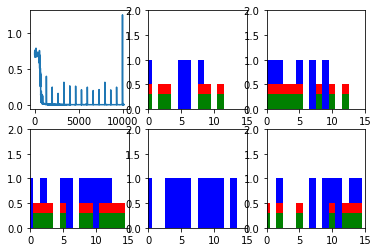

In [19]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

In [20]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*uKuUKp_m55zAPCzaIemucA.png")

In [21]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*ytquMdmGMJo0-3kxMCi1Gg.png")